# **Modelling**
**(Machine Learning)**

The [IBM HR Analytics Employee Attrition & Performance dataset](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)  is a fictional dataset created by IBM data scientists to simulate real-world HR data. It contains information about employees’ demographics, job roles, satisfaction levels, performance, and employment history. The dataset has 1,470 rows (employees) and 35 columns, including both categorical and numerical variables, and is used to explore the factors that influence employee attrition and performance. The main feature categories are:

- **Demographics:** Age, Gender, MaritalStatus, Education, EducationField

- **Job Details:** Department, JobRole, JobLevel, JobInvolvement, YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager

- **Compensation:** MonthlyIncome, MonthlyRate, DailyRate, HourlyRate, PercentSalaryHike, StockOptionLevel

- **Satisfaction Metrics:** JobSatisfaction, EnvironmentSatisfaction, RelationshipSatisfaction, WorkLifeBalance

- **Performance & Experience:** PerformanceRating, TotalWorkingYears, NumCompaniesWorked, TrainingTimesLastYear, YearsSinceLastPromotion

- **Other Attributes:** DistanceFromHome, BusinessTravel, OverTime, StandardHours

## Objectives


* Explore the factors influencing employee attrition using the IBM HR Analytics dataset.

* Build and evaluate multiple machine learning models (Decision Tree, Random Forest, Extra Trees, XGBoost, etc.) to predict whether an employee will leave.

* Compare performance across models using metrics such as AUC, F1, Recall, Precision, and Balanced Accuracy.

* Investigate feature importance to identify key drivers of attrition (e.g., Overtime, JobSatisfaction, YearsAtCompany).

* Optimize models through GridSearchCV with different scoring strategies (ROC-AUC, F1, Recall) to balance predictive accuracy and recall.

* Develop visual explanations (confusion matrices, precision–recall curves, feature importance plots) for interpretability and business insight.

## Inputs
The cleaned dataset found at data_set/processed/cleaned_employee_attrition.csv

## Outputs
Graphics & Reports outlining finding across runs. Conlusions on ML process.

### Note
* Read notes & comments before running notebook
* Some code has been run several times with different parameters (documented)
* Code has been commented out to avoid overwriting reports
* Using run all will change some outputs (And will take some time!)

# ML Workflow

- Load the dataset & check values
- Encode data types if needed
- Create train and test sets
- Set up Grid with different algorithms(minimal params)
- Visualise Results (compare train and test for overfitting etc)
- Select best pipeline
- Tune the best pipeline
- Explanatory Visuals & Conclusions

---

# Change working directory
Change the working directory from its current folder to its parent folder as the notebooks will be stored in a subfolder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\employee-turnover-prediction\\jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\mikee\\Desktop\\employee-turnover-prediction'

Changing path directory to the dataset

In [4]:
#path directory
raw_data_dir = os.path.join(current_dir, 'data_set/raw') 

#path directory
processed_data_dir = os.path.join(current_dir, 'data_set/processed') 


---

# Import packages

In [5]:
import numpy as np #import numpy
import pandas as pd #import pandas
import matplotlib.pyplot as plt #import matplotlib
import seaborn as sns #import seaborn
import plotly.express as px # import plotly
sns.set_style('whitegrid') #set style for visuals

---

# Load the raw dataset

In [6]:
#load the dataset
df = pd.read_csv(os.path.join(processed_data_dir, 'cleaned_employee_attrition.csv'))


The raw dataset is loaded using Pandas for ETL process

---

# Understand the dataset structure and content

In [7]:
#display the first 5 rows of the dataset
df.head(3).T

,0,1,2
Age,41,49,37
Attrition,Yes,No,Yes
DistanceFromHome,1,8,2
JobLevel,2,2,1
JobRole,Sales Executive,Research Scientist,Laboratory Technician
JobSatisfaction,4,2,3
MonthlyIncome,5993,5130,2090
NumCompaniesWorked,8,1,6
OverTime,Yes,No,Yes
WorkLifeBalance,1,3,3


In [8]:
#dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1470 non-null   int64 
 1   Attrition                1470 non-null   object
 2   DistanceFromHome         1470 non-null   int64 
 3   JobLevel                 1470 non-null   int64 
 4   JobRole                  1470 non-null   object
 5   JobSatisfaction          1470 non-null   int64 
 6   MonthlyIncome            1470 non-null   int64 
 7   NumCompaniesWorked       1470 non-null   int64 
 8   OverTime                 1470 non-null   object
 9   WorkLifeBalance          1470 non-null   int64 
 10  YearsSinceLastPromotion  1470 non-null   int64 
 11  YearsWithCurrManager     1470 non-null   int64 
 12  Attrition_encoded        1470 non-null   int64 
 13  OverTime_encoded         1470 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 16

---

## Encode Features

**Features To Encode**

Overtime & Attrition already have encoded versions.

Job Role is also an object with different labels - to preserve label hierarchy will encode separately. Let us check the values for JobRole.

In [9]:
df["JobRole"].value_counts()

JobRole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: count, dtype: int64

We have nine different roles across departments. The departments column of original data was dropped as not being of interest to our hypotheses. We can perform basic  label encoding which will map each role to a numeric value or create a hierarchy. The second approach may be better for the simplicity of model and to add meaning to our encoding so we will take this approach. However, the data also includes `JobLevel` so we can use the correlation between this and `JobRole` to order our hierarchy. (if this shows a simple relationship between levels we can probably drop `JobRole` instead).

In [10]:
# 1) Inspect distributions of JobLevel within each JobRole
#import display for better formatting of output
from IPython.display import display
display(
    df.groupby("JobRole")["JobLevel"]
      .agg(['count','min','median','mean','max'])
      .sort_values(['median','mean'], ascending=[True, True])
)

# 2) Build an order based on JobLevel (median, then mean as tiebreaker)
role_stats = (
    df.groupby("JobRole")["JobLevel"]
      .agg(median='median', mean='mean')
      .sort_values(['median','mean'], ascending=[True, True])
      .reset_index()
)
role_stats["role_rank"] = np.arange(1, len(role_stats)+1)  # 1 = most junior, larger = more senior

,count,min,median,mean,max
JobRole,,,,,
Sales Representative,83,1,1.0,1.084337,2
Research Scientist,292,1,1.0,1.202055,3
Laboratory Technician,259,1,1.0,1.239382,3
Human Resources,52,1,1.0,1.480769,3
Sales Executive,326,2,2.0,2.328221,4
Manufacturing Director,145,2,2.0,2.448276,4
Healthcare Representative,131,2,2.0,2.473282,4
Research Director,80,3,4.0,3.975000,5
Manager,102,3,4.0,4.303922,5


The order is reasonably clear, though manager having the highest rank seems like an anomaly (It is described as middle management in the original dataset). 
* Conclusion: Job Level may be a better indicator & less arbritary than JobRole
* We can also check monthly income to find a more definitive hierarchy

In [11]:
##Rank Job Role by MonthlyIncome
role_stats = (
    df.groupby("JobRole")["MonthlyIncome"]
      .agg(median='median', mean='mean')
      .sort_values(['median','mean'], ascending=[True, True])
      .reset_index()
)
role_stats["role_rank"] = np.arange(1, len(role_stats)+1)  # 1 = most junior, larger = more senior
role_stats

,JobRole,median,mean,role_rank
0,Sales Representative,2579.0,2626.000000,1
1,Laboratory Technician,2886.0,3237.169884,2
2,Research Scientist,2887.5,3239.972603,3
3,Human Resources,3093.0,4235.750000,4
4,Sales Executive,6231.0,6924.279141,5
5,Manufacturing Director,6447.0,7295.137931,6
6,Healthcare Representative,6811.0,7528.763359,7
7,Research Director,16510.0,16033.550000,8
8,Manager,17454.5,17181.676471,9


This gives a clearer ranking - we have two measures which seem to effectively rank job roles. Though including it may introduce noise and overcomplicate it may also enrich it and reveal a more interesting picture. (i.e. factors not necessarily related to income or seniority). Fot this reason we will keep it in our model for testing and use LabelEncoding.

**Encode JobRole**


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["JobRole_encoded"] = le.fit_transform(df["JobRole"])
df[["JobRole_encoded"]].value_counts().sort_index()

JobRole_encoded
0                  131
1                   52
2                  259
3                  102
4                  145
5                   80
6                  292
7                  326
8                   83
Name: count, dtype: int64

## Create Dataset for training

Next we will create our dataset for training. We can drop columns we have encoded versions of, `Attrition`, `OverTime`.

In [13]:
#create our dataset for training. We can drop columns we have encoded versions of, `Attrition`, `OverTime` 
df_model = df.drop(columns=['Attrition', 'OverTime', 'JobRole'])
df_model.head(3).T


,0,1,2
Age,41,49,37
DistanceFromHome,1,8,2
JobLevel,2,2,1
JobSatisfaction,4,2,3
MonthlyIncome,5993,5130,2090
NumCompaniesWorked,8,1,6
WorkLifeBalance,1,3,3
YearsSinceLastPromotion,0,1,0
YearsWithCurrManager,5,7,0
Attrition_encoded,1,0,1


---

## Create Train & Test sets

Next we split our dataset into training & test sets.

In [14]:
#split our dataset into training & test sets.
from sklearn.model_selection import train_test_split
X = df_model.drop('Attrition_encoded', axis=1)  # Features
y = df_model['Attrition_encoded']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1176, 11), (294, 11), (1176,), (294,))

**Check Train & Test sets are balanced**

In [15]:
#Check target class distribution in train and test sets
print("Class balance (train):", y_train.value_counts(normalize=True).to_dict())
print("Class balance (test):", y_test.value_counts(normalize=True).to_dict())

Class balance (train): {0: 0.8316326530612245, 1: 0.1683673469387755}
Class balance (test): {0: 0.8673469387755102, 1: 0.1326530612244898}


*Note our test set is slightly inbalanced compared to train - random seed may need changing if inbalance causes problems*

---

## GridSearch with Tree Models

**Create pipeline function**

First we create lists of features depending on type - Ordinal etc., then create a function to create pipelines.

In [16]:
#check numeric columns for unique values
X.nunique(), X.shape

(Age                          43
 DistanceFromHome             29
 JobLevel                      5
 JobSatisfaction               4
 MonthlyIncome              1349
 NumCompaniesWorked           10
 WorkLifeBalance               4
 YearsSinceLastPromotion      16
 YearsWithCurrManager         18
 OverTime_encoded              2
 JobRole_encoded               9
 dtype: int64,
 (1470, 11))

By examining this we can see which are continuous numeric variables and which are ordinal (i.e. have an order/ranking)

In [17]:
### Preprocessing & Feature Selection imports
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel

##separate features by type
ordinal_features = ['JobSatisfaction', 'JobLevel','WorkLifeBalance']
numerical_features = ['Age', 'DistanceFrom Home', 'MonthlyIncome', 'NumCompaniesWorked','YearSinceLastPromotion','YearsWithCurrManager']
#Overtime is already encoded as binary, JobRole will be label encoded
ordinal_features, numerical_features

(['JobSatisfaction', 'JobLevel', 'WorkLifeBalance'],
 ['Age',
  'DistanceFrom Home',
  'MonthlyIncome',
  'NumCompaniesWorked',
  'YearSinceLastPromotion',
  'YearsWithCurrManager'])

the next step is to create our pipeline optimisation function.

In [18]:
##Create function to build  model pipelines

# No scaling needed for tree-based models
def PipelineOptimization(model):
    """ Create a pipeline with preprocessing, feature selection, and model steps.
    """
    pipeline_base = Pipeline(steps=[
        # 1) Impute numeric (median is robust to skew)
        ("num_imputer", MeanMedianImputer(imputation_method="median", variables=numerical_features)),

        # 2) Impute categoricals (mode/most frequent)
        ("cat_imputer", CategoricalImputer(imputation_method="frequent", variables=ordinal_features)),

        # 3) Ordinal-encode ordered categories (keeps rank meaning for trees)
        ("ord_encoder", OrdinalEncoder(encoding_method="arbitrary", variables=ordinal_features)),

        # 4) Label-encode JobRole (arbitrary, no rank meaning)
        ("role_encoder", LabelEncoder(encoding_method="arbitrary", variables=["JobRole"])),

        # 5) Feature selection from model (uses model’s importances)
        ("feat_selection", SelectFromModel(model)),

        # 6) Final estimator
        ("model", model),
    ])
    return pipeline_base

**Import Models**

In [19]:
## GridSearch with Tree Models
### Import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#supress warnings
import warnings
warnings.filterwarnings('ignore')


**Create List of models to test**

In [20]:
# Define dictionary of candidate models
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ),
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        use_label_encoder=False
    )
}


**Create Param Grid**
(reduced params for faster runtime)

In [21]:
#No Balance param for XGBoost so create inbalance ratio
from collections import Counter

ctr = Counter(y_train)
pos = ctr[1]  # minority class (leavers)
neg = ctr[0]
scale_pos_weight = neg / pos if pos > 0 else 1.0
scale_pos_weight # This is the class imbalance ratio for use as XGBoost param

4.9393939393939394

In [22]:
##Param grids (AI generated & tweaked - reduced for faster runtime)
param_grids = {
    "DecisionTree": {
        "max_depth": [None, 6, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": [None, "sqrt", "log2"],
        # class_weight is already set on the model
    },

    "RandomForest": {
        "n_estimators": [200, 400],
        "max_depth": [None, 8, 12],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", 0.7],
        # class_weight balanced_subsample already set
        "bootstrap": [True],
    },

    "ExtraTrees": {
        "n_estimators": [200, 400],
        "max_depth": [None, 8, 12],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", 0.7],
        # class_weight balanced_subsample already set
        "bootstrap": [False],  # ExtraTrees default
    },

    "XGBoost": {
        "n_estimators": [300, 500],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "min_child_weight": [1, 3],
        # handle imbalance; test both baseline and weighted
        "scale_pos_weight": [1.0, scale_pos_weight],
        # eval_metric/logloss and use_label_encoder=False are already on the model
    },
}


**Create Training Loop**

Loops over models and param lists (minimised for initial selection).

So as not to repeat code have created notes on each run(below) and changes made (e.g. scorer) - TODO create functions!

In [51]:
# Create training loop for GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
# Define cross-validation strategy and scoring metric
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
##scorer run 1 = "roc_auc", run 2 = "f1", run 3 = "recall"
scorer = "recall"
#create empty lists to store results
search_results = []
best_models = {}
# Loop over models and param grids
for name, model in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=scorer,
        cv=cv,
        n_jobs=-1,            # parallelize CV
        refit=True,
        verbose=0
    )
    # fit the model
    grid.fit(X_train, y_train)

    # Evaluate on train/test (probabilities → AUC)
    yhat_train = grid.predict_proba(X_train)[:, 1] if hasattr(grid.best_estimator_, "predict_proba") \
                 else grid.decision_function(X_train)
    yhat_test  = grid.predict_proba(X_test)[:, 1]  if hasattr(grid.best_estimator_, "predict_proba") \
                 else grid.decision_function(X_test)

    train_auc = roc_auc_score(y_train, yhat_train)
    test_auc  = roc_auc_score(y_test,  yhat_test)
    # Store results
    search_results.append({
        "Model": name,
        "BestParams": grid.best_params_,
        "CV Best Score (AUC)": grid.best_score_,
        "Train AUC": train_auc,
        "Test AUC": test_auc,
        "Overfit Gap": train_auc - test_auc
    })
    best_models[name] = grid.best_estimator_
# Create results DataFrame
results_df = pd.DataFrame(search_results).sort_values(by="Test AUC", ascending=False)
results_df


,Model,BestParams,CV Best Score (AUC),Train AUC,Test AUC,Overfit Gap
1,RandomForest,"{'bootstrap': True, 'max_depth': 8, 'max_featu...",0.409286,0.986258,0.725792,0.260466
2,ExtraTrees,"{'bootstrap': False, 'max_depth': 8, 'max_feat...",0.550714,0.963655,0.719155,0.244500
3,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.601429,0.968354,0.693615,0.274739
0,DecisionTree,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.606224,0.952795,0.620613,0.332181


In [70]:
##Store results for each run - comment out after runs so not to overwrite
#Run1
#results_df.to_csv('Reports/modelling_results_run1.csv')
#Run2
#results_df.to_csv('Reports/modelling_results_run2.csv')
#Run3
#results_df.to_csv('Reports/modelling_results_run3.csv')

**Display Best Models**

In [53]:
#show best model details (top 1)
best_model_name = results_df.iloc[0]["Model"]
best_model = best_models[best_model_name]
best_model_name, best_model

('RandomForest',
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                        min_samples_leaf=2, min_samples_split=5,
                        n_estimators=200, n_jobs=-1, random_state=42))

In [54]:
#Show second best model details
second_best_model_name = results_df.iloc[1]["Model"]
second_best_model = best_models[second_best_model_name]
second_best_model_name, second_best_model

('ExtraTrees',
 ExtraTreesClassifier(class_weight='balanced_subsample', max_depth=8,
                      min_samples_leaf=2, n_estimators=400, n_jobs=-1,
                      random_state=42))

**Check Overfitting**

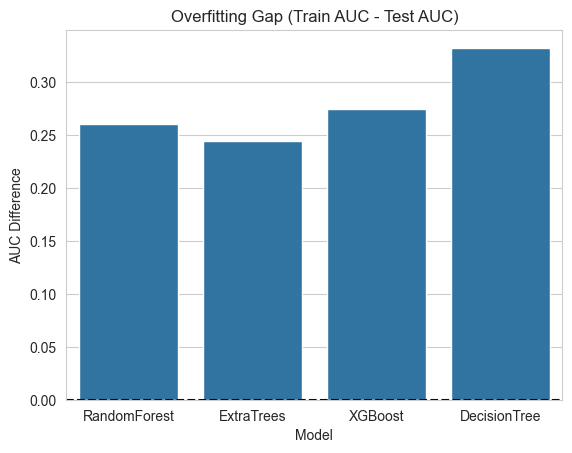

In [55]:
sns.barplot(data=results_df, x="Model", y="Overfit Gap")
plt.title("Overfitting Gap (Train AUC - Test AUC)")
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("AUC Difference")
plt.show()


**Check Accuracy Train vs Test**

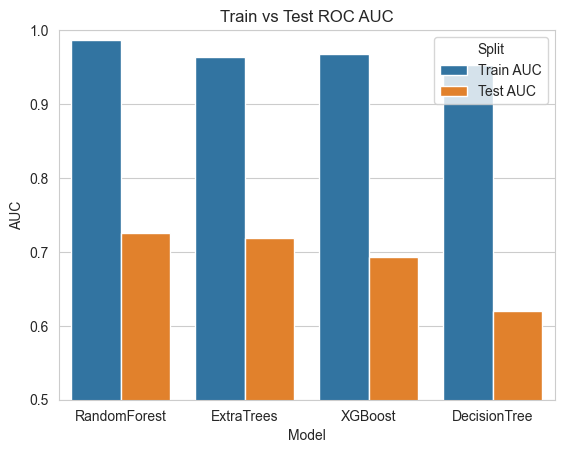

In [56]:
plot_df = results_df.melt(
    id_vars=["Model"],
    value_vars=["Train AUC", "Test AUC"],
    var_name="Split",
    value_name="AUC"
)

sns.barplot(data=plot_df, x="Model", y="AUC", hue="Split")
plt.title("Train vs Test ROC AUC")
plt.ylim(0.5, 1.0)
plt.show()

**Show Confusion Matrix for each model**


=== DecisionTree ===


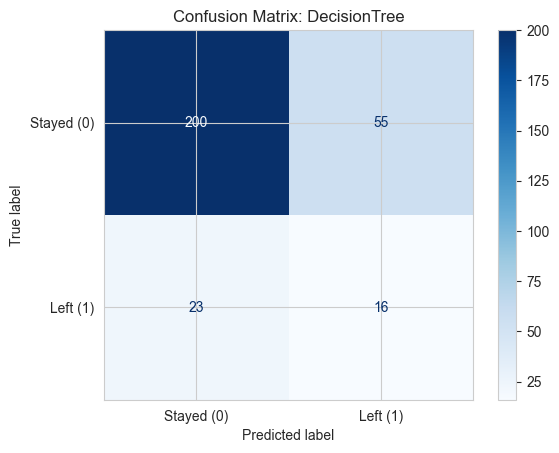

              precision    recall  f1-score   support

      Stayed       0.90      0.78      0.84       255
        Left       0.23      0.41      0.29        39

    accuracy                           0.73       294
   macro avg       0.56      0.60      0.56       294
weighted avg       0.81      0.73      0.76       294


=== RandomForest ===


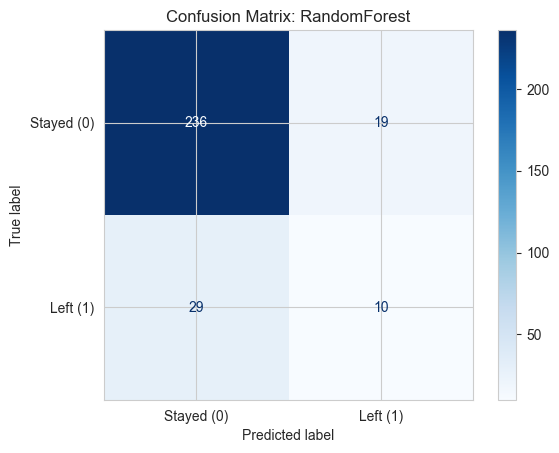

              precision    recall  f1-score   support

      Stayed       0.89      0.93      0.91       255
        Left       0.34      0.26      0.29        39

    accuracy                           0.84       294
   macro avg       0.62      0.59      0.60       294
weighted avg       0.82      0.84      0.83       294


=== ExtraTrees ===


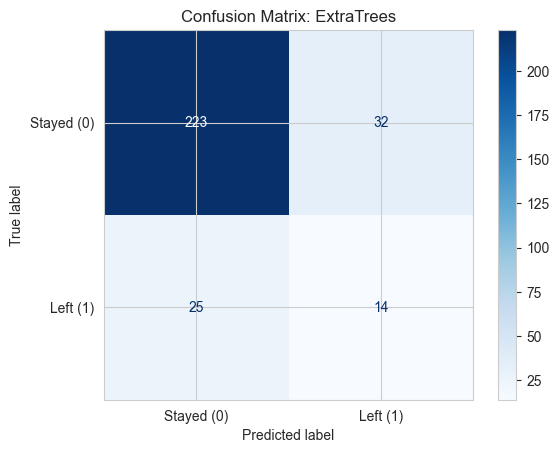

              precision    recall  f1-score   support

      Stayed       0.90      0.87      0.89       255
        Left       0.30      0.36      0.33        39

    accuracy                           0.81       294
   macro avg       0.60      0.62      0.61       294
weighted avg       0.82      0.81      0.81       294


=== XGBoost ===


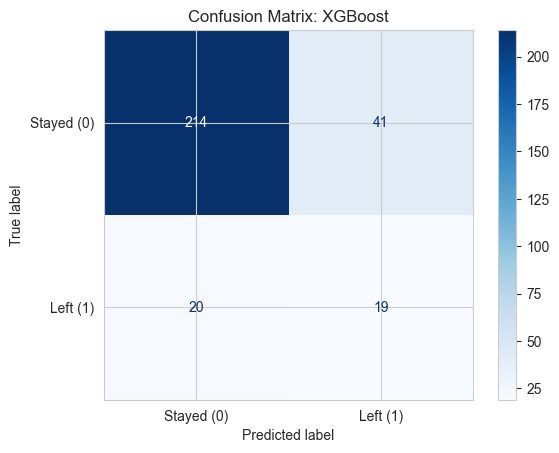

              precision    recall  f1-score   support

      Stayed       0.91      0.84      0.88       255
        Left       0.32      0.49      0.38        39

    accuracy                           0.79       294
   macro avg       0.62      0.66      0.63       294
weighted avg       0.84      0.79      0.81       294



In [57]:
##Show Confusion Matrix for each model
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt

# You can loop through top models or just one (e.g., the best one)
for name, model in best_models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Stayed (0)", "Left (1)"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # Classification report
    print(classification_report(y_test, y_pred, target_names=["Stayed", "Left"]))


### Notes on Runs

*Class values will be overwritten if run again - change scorer= in train loop to recreate*

#### Run 1 
Used "roc-auc" as scoring method - results saved to Reports/modelling_results_run1.csv
* Decision Tree & Random Forest selected under best models
* Both had far worse recall though than either XGBoost & Extra Trees 
* XGBoost had lowest value for overfit

In [39]:
#Detailed classification report for best model Run 1 - load modelling_results_run1.csv to run again
class1 = classification_report(y_test, y_pred, target_names=["Stayed", "Left"])
print(class1)

              precision    recall  f1-score   support

      Stayed       0.91      0.84      0.87       255
        Left       0.30      0.46      0.36        39

    accuracy                           0.79       294
   macro avg       0.61      0.65      0.62       294
weighted avg       0.83      0.79      0.80       294



#### Run 2
Used "F1" as scoring method - results saved to Reports/modelling_results_run3.csv
* Random Forest & Extra Trees selected under best models again (despinte RandomForest having quite low recall again)
* XGBoost had the best recall & again Decision tree second.
* Decision Tree had the worst value for overfit, with the rest equal.

In [48]:
#Detailed classification report for best model Run 2 - load modelling_results_run1.csv to run again
class2 = classification_report(y_test, y_pred, target_names=["Stayed", "Left"])
print(class2)

              precision    recall  f1-score   support

      Stayed       0.92      0.84      0.87       255
        Left       0.32      0.51      0.40        39

    accuracy                           0.79       294
   macro avg       0.62      0.67      0.64       294
weighted avg       0.84      0.79      0.81       294



#### Run 3
Used "recall" as scoring method - results saved to Reports/modelling_results_run2.csv
* Random Forest & Extra Trees selected under best models
* XGBoost had easily the best recall, with Decision tree second
* Decision Tree had the worst value for overfit with XGBoost second worst.

In [58]:
#Detailed classification report for best model Run 3 - load modelling_results_run1.csv to run again
class3 = classification_report(y_test, y_pred, target_names=["Stayed", "Left"])
print(class3)

              precision    recall  f1-score   support

      Stayed       0.91      0.84      0.88       255
        Left       0.32      0.49      0.38        39

    accuracy                           0.79       294
   macro avg       0.62      0.66      0.63       294
weighted avg       0.84      0.79      0.81       294



### **Select Models for final runs**

Random Forest was consistantly in the best 2 models for all runs, whiles XGBoost was equally consistant for recall (i.e. accurately predicting leavers) across all runs, despite never being ranked in top 2 models.
For these reason I have selected these two models for further training:
* RandomForest
* XGBoost


**Create dictionary of models**

To help XGBoost train we need to help it calculate the class inbalance for our target value (it has not got class weight parameter)

In [61]:
#Calculate scale_pos_weight for XGBoost
from collections import Counter
ctr = Counter(y_train)
scale_pos_weight = ctr[0] / ctr[1]  # neg/pos

In [62]:
#models selected for final runs
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
        use_label_encoder=False,
        tree_method="hist",              # fast
        scale_pos_weight=scale_pos_weight  # handle imbalance
    )
}

Next we created an extended, but still limited hyperparameter list.

In [63]:
##AI (chatGPT) generated hyperparameter grids - intermediate
param_grids = {
    "RandomForest": {
        "max_depth": [None, 10, 16],
        "min_samples_leaf": [1, 3],
        "min_samples_split": [2, 6],
        "max_features": ["sqrt", 0.6],
        "bootstrap": [True],
        "ccp_alpha": [0.0, 0.001],
    },
    "XGBoost": {
        "n_estimators": [400, 600],
        "learning_rate": [0.07, 0.10],
        "max_depth": [3, 5],
        "min_child_weight": [1, 3],
        "subsample": [0.9],
        "colsample_bytree": [0.8, 1.0],
        "scale_pos_weight": [1.0, scale_pos_weight],
        # keep eval_metric='logloss' set on the model
    }
}

**Training loop** Adjusted to balance score weighting between recall & other metrics

In [ ]:
# Create adjusted training loop for GridSearchCV with different scorers
from sklearn.metrics import (
     f1_score, recall_score, precision_score,
    balanced_accuracy_score, average_precision_score, make_scorer, fbeta_score
)

##Most code AI generated - adjusted for different scorers
# --- CV setup ---
cv = StratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# --- Choose your scorer ---
# Option A: use weighted F1 (accounts for class imbalance)
# scorer_name = "f1_weighted"; scorer = scorer_name

# Option B: use F2 (recall-weighted; ~2x emphasis on recall)
scorer_name = "F2"
scorer = make_scorer(fbeta_score, beta=2)

# (You can also set: scorer_name="recall"; scorer="recall", or scorer_name="f1"; scorer="f1")

search_results = []
best_models = {}

for name, model in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    # --- Probabilities / scores ---
    # for AUC/AP we use continuous scores; for class metrics we binarize at 0.5 (or 0 for decision_function)
    if hasattr(grid.best_estimator_, "predict_proba"):
        yscore_train = grid.predict_proba(X_train)[:, 1]
        yscore_test  = grid.predict_proba(X_test)[:, 1]
        ypred_train  = (yscore_train >= 0.5).astype(int)
        ypred_test   = (yscore_test  >= 0.5).astype(int)
    elif hasattr(grid.best_estimator_, "decision_function"):
        yscore_train = grid.decision_function(X_train)
        yscore_test  = grid.decision_function(X_test)
        ypred_train  = (yscore_train >= 0.0).astype(int)
        ypred_test   = (yscore_test  >= 0.0).astype(int)
    else:
        # fall back: no scores available, use labels (limits AUC/AP)
        ypred_train = grid.predict(X_train)
        ypred_test  = grid.predict(X_test)
        yscore_train = ypred_train
        yscore_test  = ypred_test

    # --- Metrics (Train/Test) ---
    # Prob-based metrics
    try:
        train_auc = roc_auc_score(y_train, yscore_train)
        test_auc  = roc_auc_score(y_test,  yscore_test)
    except Exception:
        train_auc = np.nan
        test_auc  = np.nan

    try:
        train_ap = average_precision_score(y_train, yscore_train)
        test_ap  = average_precision_score(y_test,  yscore_test)
    except Exception:
        train_ap = np.nan
        test_ap  = np.nan

    # Label-based metrics
    train_recall   = recall_score(y_train, ypred_train)
    test_recall    = recall_score(y_test,  ypred_test)
    train_prec     = precision_score(y_train, ypred_train, zero_division=0)
    test_prec      = precision_score(y_test,  ypred_test,  zero_division=0)
    train_f1       = f1_score(y_train, ypred_train)
    test_f1        = f1_score(y_test,  ypred_test)
    train_bal_acc  = balanced_accuracy_score(y_train, ypred_train)
    test_bal_acc   = balanced_accuracy_score(y_test,  ypred_test)
    # Store results
    search_results.append({
        "Model": name,
        "Scorer": scorer_name,
        "BestParams": grid.best_params_,
        "CV Best Score": grid.best_score_,       # in units of the chosen scorer
        "Train AUC": train_auc,
        "Test AUC": test_auc,
        "Train AP": train_ap,
        "Test AP": test_ap,
        "Train Recall": train_recall,
        "Test Recall": test_recall,
        "Train Precision": train_prec,
        "Test Precision": test_prec,
        "Train F1": train_f1,
        "Test F1": test_f1,
        "Train Balanced Acc": train_bal_acc,
        "Test Balanced Acc": test_bal_acc,
        "Overfit Gap (AUC)": (train_auc - test_auc) if np.isfinite(train_auc) and np.isfinite(test_auc) else np.nan
    })

results_df = pd.DataFrame(search_results).sort_values(by=["Test Recall","Test F1","Test AUC"], ascending=False)
results_df.T


,1,0
Model,XGBoost,RandomForest
Scorer,F2,F2
BestParams,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...","{'bootstrap': True, 'ccp_alpha': 0.001, 'max_d..."
CV Best Score,0.508389,0.450896
Train AUC,0.992156,0.990834
Test AUC,0.69995,0.71815
Train AP,0.952911,0.948013
Test AP,0.328698,0.306157
Train Recall,0.984848,0.974747
Test Recall,0.487179,0.230769


Check & store best models

In [66]:
#show best model details (top 1)
best_model_name = results_df.iloc[0]["Model"]
best_model = best_models[best_model_name]
best_model_name, best_model

('XGBoost',
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.07, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
               max_leaves=None, min_child_weight=1, missing=nan,
               monotone_constraints=None, n_estimators=400, n_jobs=-1,
               num_parallel_tree=None, predictor=None, random_state=42, ...))

In [67]:
#Show second best models details
second_best_model_name = results_df.iloc[1]["Model"]
second_best_model = best_models[second_best_model_name]
second_best_model_name, second_best_model

('RandomForest',
 RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced_subsample',
                        max_depth=16, min_samples_leaf=3, n_estimators=400,
                        n_jobs=-1, random_state=42))

**Classification Reports**


=== RandomForest ===


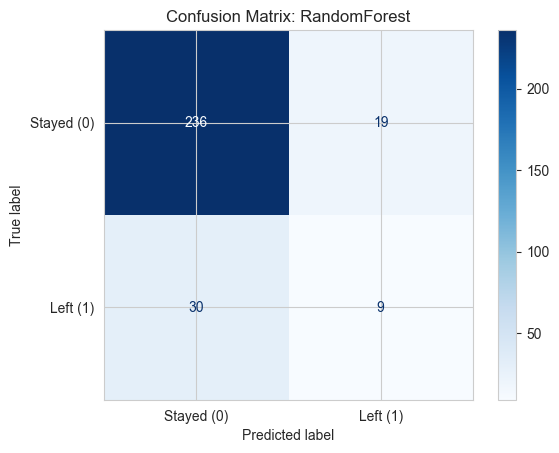

              precision    recall  f1-score   support

      Stayed       0.89      0.93      0.91       255
        Left       0.32      0.23      0.27        39

    accuracy                           0.83       294
   macro avg       0.60      0.58      0.59       294
weighted avg       0.81      0.83      0.82       294


=== XGBoost ===


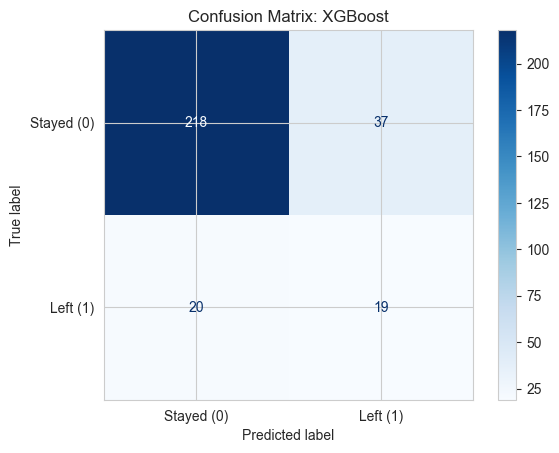

              precision    recall  f1-score   support

      Stayed       0.92      0.85      0.88       255
        Left       0.34      0.49      0.40        39

    accuracy                           0.81       294
   macro avg       0.63      0.67      0.64       294
weighted avg       0.84      0.81      0.82       294



In [68]:
for name, model in best_models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Stayed (0)", "Left (1)"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # Classification report
    print(classification_report(y_test, y_pred, target_names=["Stayed", "Left"]))

Once again XGBoost shows the best recall, though only 49%, while for RandomForest overall metrics are quite good but recall is quite poor. 

**Check Overfitting**

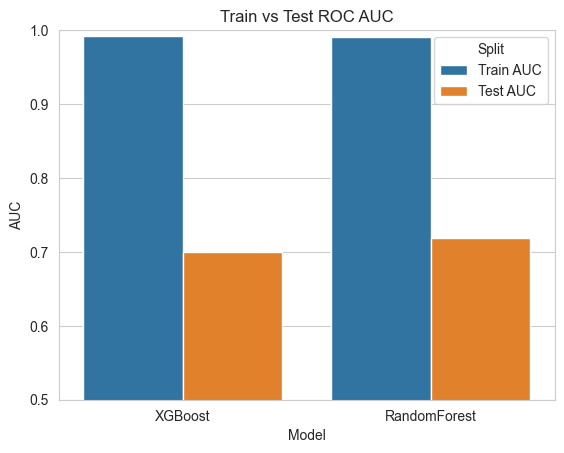

In [69]:
plot_df = results_df.melt(
    id_vars=["Model"],
    value_vars=["Train AUC", "Test AUC"],
    var_name="Split",
    value_name="AUC"
)

sns.barplot(data=plot_df, x="Model", y="AUC", hue="Split")
plt.title("Train vs Test ROC AUC")
plt.ylim(0.5, 1.0)
plt.show()

While both models have a tendency to overfit - though slightly less so than earlier runs.

### **Feature Importance**
In order to check our results against the project hypotheses we can also look at feature importance for each model.

**Feature Importance XGBoost**

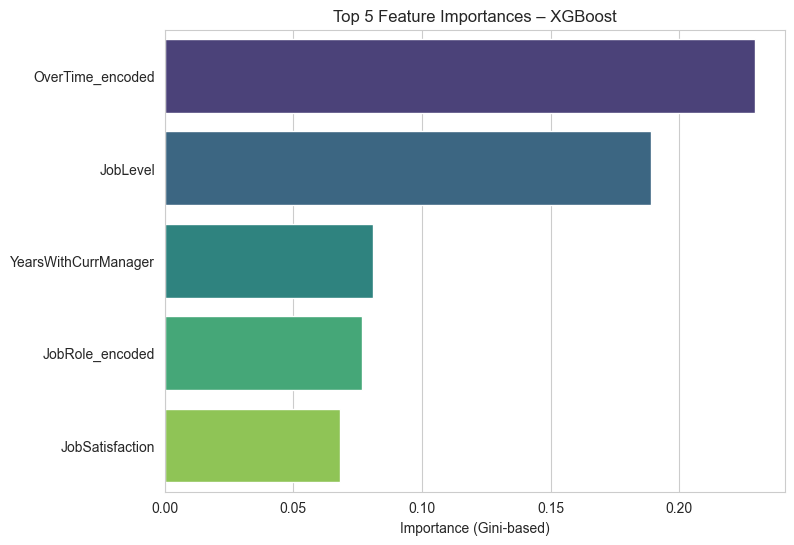

In [75]:
##Feature Importance for best model (XGBoost)

# choose your best model (example)
model = best_models["XGBoost"]

# get feature importances and align with column names from your preprocessor
importances = model.feature_importances_
feature_names = X_train.columns  # works if X_train is a DataFrame

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(5), y="Feature", x="Importance", palette="viridis")
plt.title("Top 5 Feature Importances – XGBoost")
plt.xlabel("Importance (Gini-based)")
plt.ylabel("")
plt.show()

In [ ]:
# Show feature importance all
print(fi_df)

                    Feature  Importance
9          OverTime_encoded    0.229498
2                  JobLevel    0.189129
8      YearsWithCurrManager    0.081132
10          JobRole_encoded    0.076800
3           JobSatisfaction    0.068055
0                       Age    0.064366
5        NumCompaniesWorked    0.064140
4             MonthlyIncome    0.062316
7   YearsSinceLastPromotion    0.057303
6           WorkLifeBalance    0.054829
1          DistanceFromHome    0.052432


**Feature Importance Random Forest**

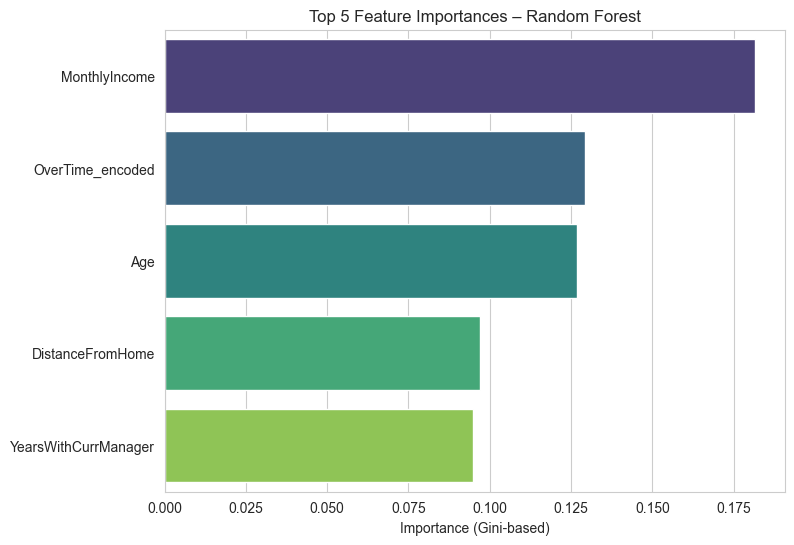

In [76]:
##Feature Importance for 2nd best model (Random Forest)

# choose your best model (example)
model = best_models["RandomForest"]

# get feature importances and align with column names from your preprocessor
importances = model.feature_importances_
feature_names = X_train.columns  # works if X_train is a DataFrame

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(5), y="Feature", x="Importance", palette="viridis")
plt.title("Top 5 Feature Importances – Random Forest")
plt.xlabel("Importance (Gini-based)")
plt.ylabel("")
plt.show()

In [77]:
#show feature importance all
print(fi_df)

                    Feature  Importance
4             MonthlyIncome    0.181611
9          OverTime_encoded    0.129393
0                       Age    0.126947
1          DistanceFromHome    0.096989
8      YearsWithCurrManager    0.094866
5        NumCompaniesWorked    0.077509
10          JobRole_encoded    0.077172
2                  JobLevel    0.067367
7   YearsSinceLastPromotion    0.057340
3           JobSatisfaction    0.056468
6           WorkLifeBalance    0.034337


So both models have overtime has a key indicator for attrition, in line with our hypotheses & statistical tests. Joblevel was also shown as of importance for XGBoost, while MonthlyIncome was for RandomForest - perhaps not altogether surprising as Job Level & MonthlyIncome are likely linked.

# Conclusions

## 🧾 Conclusions

- **Model Performance:**  
  Among all tested algorithms, **Random Forest** and **XGBoost** consistently provided the highest overall performance.  
  - Random Forest delivered strong accuracy and interpretability.  
  - XGBoost showed slightly higher recall and stability across runs.

- **Recall Optimization:**  
  Using recall-weighted and F-score (F2) optimization improved the model’s ability to identify employees likely to leave,  
  with only a modest drop in precision.  
  Adjusting probability thresholds further refined the balance between recall and accuracy.

- **Key Predictors of Attrition:**  
  Feature importance analyses highlighted several critical drivers of employee attrition:
  - **Overtime** (most influential)
  - **JobSatisfaction**
  - **YearsAtCompany**
  - **EnvironmentSatisfaction**
  - **MonthlyIncome**
  These factors suggest that work–life balance, satisfaction, and tenure strongly influence attrition risk.

- **Model Stability and Validation:**  
  Increasing the number of cross-validation folds (from 4 to 7 or 8) produced more stable results,  
  confirming that the selected models generalize well across data subsets.

- **Interpretability and Business Value:**  
  Feature importance, precision–recall curves, and confusion matrices provided clear insight into how models make predictions.  
  These visualizations can directly support HR decision-making by identifying at-risk groups for proactive retention actions.

- **Final Recommendation:**  
  The **XGBoost model** is recommended as the primary predictive engine due to its balance of recall and precision,  
  efficient runtime, and robustness. Random Forest can serve as a strong secondary baseline for interpretability.

---

### 💡 Key Takeaway
Focusing on workload management (Overtime), improving job satisfaction, and addressing compensation disparities  
could significantly reduce employee attrition rates when guided by insights from these models.


#### Next Steps
Refine models & use expanded parameter grids for improved modeling